<a href="https://colab.research.google.com/github/asgutierrt/health_robot/blob/main/hospital_abms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mesa
!pip install mesa_geo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.4/106.4 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
import mesa
import mesa_geo as mg
import json
# Opening geoJSON files
with open('unisabana_hospital_floor.geojson') as file:
  hospital_rooms = json.load(file)
with open('unisabana_hospital_rooms.geojson') as file:
  hospital_rooms = json.load(file)

# agents

In [6]:
class Hospital(mg.GeoAgent):
    def __init__(self, unique_id, model, geometry, crs):
        super().__init__(unique_id, model, geometry, crs)
        self.color_hotspot()

    def color_hotspot(self):
      # Decide if there are agents here
      residents = self.model.space.get_intersecting_agents(self)
      patients_here = [resident for resident in residents if resident.atype == "patient"]

      if len(patients_here) >= 1:
          self.atype = "ocupied"
      else:
          self.atype = "empty"

    def __repr__(self):
        return "Hospital space " + str(self.unique_id)

from shapely.geometry import Point
class PersonAgent(mg.GeoAgent):
    """Person Agent."""
    def __init__( self, unique_id, model, geometry, crs,
        agent_type="patient",
        mobility_range=100, # movement per step
        recovery_rate=0.2,
        death_risk=0.1,
        p_worker=0.9,
    ):
        super().__init__(unique_id, model, geometry, crs)
        # Agent parameters
        self.atype = agent_type
        self.mobility_range = mobility_range

        # Random choose if healthcare worker
        if self.random.random() < p_worker:
            self.atype = "medical provider"
            self.model.counts["patient"] -= 1  # Adjust initial counts
            self.model.counts["medical provider"] += 1

    def move_point(self, dx, dy):
        """
        Move a point by creating a new one
        :param dx:  Distance to move in x-axis
        :param dy:  Distance to move in y-axis
        """
        return Point(self.geometry.x + dx, self.geometry.y + dy)

    def step(self):
        """Advance one step."""
        if self.random.random() < self.death_risk: self.atype = "dead"

        # If not dead, move
        if self.atype != "dead":
            move_x = self.random.randint(-self.mobility_range, self.mobility_range)
            move_y = self.random.randint(-self.mobility_range, self.mobility_range)
            self.geometry = self.move_point(move_x, move_y)  # Reassign geometry

        self.model.counts[self.atype] += 1  # Count agent type

    def __repr__(self):
        return "Person " + str(self.unique_id)

# Model

In [7]:
class GeoModel(mesa.Model):
    with open('unisabana_hospital_rooms.geojson') as file:
      hospital_rooms = json.load(file)

    def __init__(self, pop_size=3, p_worker=0.2):

        self.schedule = mesa.time.BaseScheduler(self)
        self.space = mg.GeoSpace(warn_crs_conversion=False)
        self.steps = 0
        self.counts = None
        self.reset_counts()

        # model parameters
        self.pop_size = pop_size
        self.counts["patient"] = pop_size

        self.running = True
        self.datacollector = mesa.DataCollector(
            {
                "patient": get_patient_count,
                "medical provider": get_med_count,
                "dead": get_dead_count,
            }
        )

        # Set up the Neighbourhood patches for every region in file
        # (add to schedule later)
        ac = mg.AgentCreator(agent_class=Hospital, model=self)
        neighbourhood_agents = ac.from_GeoJSON(self.hospital_rooms)
        self.space.add_agents(neighbourhood_agents)

        # Generate PersonAgent population
        ac_population = mg.AgentCreator( PersonAgent, model=self, crs=self.space.crs )

        # Generate random location, add agent to grid and scheduler
        for i in range(pop_size):
             # Region where agent starts
            this_neighbourhood = self.random.randint(0, len(neighbourhood_agents) - 1)

            center_x, center_y = neighbourhood_agents[this_neighbourhood].geometry.centroid.coords.xy
            this_bounds = neighbourhood_agents[this_neighbourhood].geometry.bounds

            # Heuristic for agent spread in region
            spread_x = int(this_bounds[2] - this_bounds[0])
            spread_y = int(this_bounds[3] - this_bounds[1])
            this_x = center_x[0] + self.random.randint(0, spread_x) - spread_x / 2
            this_y = center_y[0] + self.random.randint(0, spread_y) - spread_y / 2

            # create and place Person
            this_person = ac_population.create_agent(Point(this_x, this_y), "P" + str(i))
            self.space.add_agents(this_person)
            self.schedule.add(this_person)

        # Add the neighbourhood agents to schedule AFTER person agents,
        # to allow them to update their color by using BaseScheduler
        for agent in neighbourhood_agents:
            self.schedule.add(agent)

        self.datacollector.collect(self)

    def reset_counts(self):
      self.counts = {
          "patient": 0,
          "medical provider": 0,
          "dead": 0,
          "ocupied": 0,
          "empty": 0}

    def step(self):
        """Run one step of the model."""
        self.steps += 1
        self.reset_counts()
        self.schedule.step()
        # Recalculate spatial tree, because agents are moving
        self.space._recreate_rtree()

        self.datacollector.collect(self)

        # Run until no one is in hospital
        if self.counts["patient"] == 0 and self.counts["medical provider"]==0:
            self.running = False


# Functions needed for datacollector
def get_patient_count(model): return model.counts["patient"]
def get_med_count(model): return model.counts["medical provider"]
def get_dead_count(model): return model.counts["dead"]

# server

In [9]:
class Text(mesa.visualization.TextElement):
    """
    Display a text
    """
    def __init__(self):
        pass

    def render(self, model):
        return "Steps: " + str(model.steps)


model_params = {
    "pop_size": mesa.visualization.Slider("Population size", 30, 10, 100, 10),
}

def agent_draw(agent):
    """
    Portrayal Method for canvas
    """
    portrayal = {}
    if isinstance(agent, PersonAgent): portrayal["radius"] = "2"

    if agent.atype in ["ocupied"]: portrayal["color"] = "Red"
    elif agent.atype in ["empty"]: portrayal["color"] = "Green"

    elif agent.atype in ["patient"]: portrayal["color"] = "Grey"
    elif agent.atype in ["medical provider"]: portrayal["color"] = "Black"
    elif agent.atype in ["dead"]: portrayal["color"] = "Yellow"
    return portrayal


map_element = mg.visualization.MapModule(agent_draw)
agents_chart = mesa.visualization.ChartModule(
    [
        {"Label": "medical provider", "Color": "Black"},
        {"Label": "patient", "Color": "Grey"},
        {"Label": "dead", "Color": "Yellow"},
    ]
)

server = mesa.visualization.ModularServer(
    GeoModel,
    [map_element, Text(), agents_chart],
    "agent-based model",
    model_params,
)

In [10]:
server.launch()

Interface starting at http://127.0.0.1:8521


OSError: ignored

0


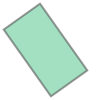

In [6]:
m = GeoModel()
agent = m.space.agents[0]
print(agent.unique_id)
agent.geometry

In [7]:
info=lambda agent: [agent.name, agent.Id]
info(agent)

['room', '204']

In [8]:
neighbors = m.space.get_neighbors(agent)
neighbors = m.space.get_neighbors_within_distance(agent, 4)
[info(a) for a in neighbors]

/usr/local/lib/python3.10/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
 There are 8 islands with ids: 1, 2, 3, 4, 5, 6, 30, 42.
  warnings.warn(message)


[['bed', '0'],
 ['room', '204'],
 ['bed', '1'],
 ['bed', '3'],
 ['room', '203'],
 ['bed', '2']]

In [10]:
m.space.agents[1].name

'nurse'

In [36]:
import mesa
import mesa_geo as mg


class State(mg.GeoAgent):
    def __init__(self, unique_id, model, geometry, crs):
        super().__init__(unique_id, model, geometry, crs)


class GeoModel(mesa.Model):
    geojson_states = "TorontoNeighbourhoods.geojson"
    def __init__(self):
        self.space = mg.GeoSpace()
        ac = mg.AgentCreator(agent_class=State, model=self)
        agents = ac.from_file(geojson_states)
        self.space.add_agents(agents)

0


/usr/local/lib/python3.10/dist-packages/mesa_geo/geospace.py:138: UserWarning: Converting State from crs EPSG:4326 to the crs of GeoSpace - EPSG:3857. Please check your crs settings if this is unintended, or set `GeoSpace.warn_crs_conversion` to `False` to suppress this warning message.
  warnings.warn(


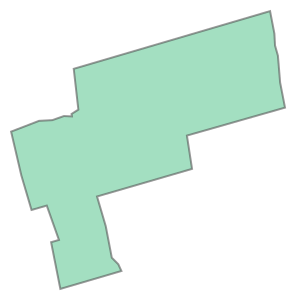

In [37]:
m = GeoModel()

agent = m.space.agents[0]
print(agent.unique_id)
agent.geometry

In [39]:
agent.HOODNUM

103